<a href="https://colab.research.google.com/github/datnguyen0328/stock-price-prediction/blob/main/stock_price_fluctuations_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement**

The objective of this project is to predict the fluctuation in stock prices using an LSTM (Long Short-Term Memory) neural network. The fluctuation is defined as the difference between the closing price in the future and the current closing price. To achieve this, the solution involves predicting the future closing prices, from which the fluctuation can be derived. The solution is implemented in three main steps: data visualization, data preprocessing, and model training using LSTM.

1. **Step 1: Data Visualization**

* In the provided solution, data visualization includes plotting various statistical measures such as the difference between high and low prices (H-L), the difference between open and close prices (O-C), and the simple moving averages (SMA) over different windows. These visualizations help in understanding the volatility and trend of the stock prices over time.

2. **Step 2: Data Preprocessing**
Data preprocessing involves cleaning and transforming the raw data into a format suitable for training the model. This step includes:

* Feature Engineering: Creating new features that capture important aspects of the stock price data. In this solution, features like H-L, O-C, SMA_7, SMA_14, SMA_21, SD_7, SD_21, and the Fluctuation (difference between Close and Close.shift(-10)) are engineered.

* Scaling: Scaling the data to bring all features to a similar range, which is important for neural network models. The MinMaxScaler is used to scale the features and target variables.

* Train-Test Split: Splitting the data into training and testing sets. Each company's data is processed separately, and the data is combined for model training. The training and testing sets are created in a way that the model can learn from the historical data and generalize well on unseen data.

3. **Step 3: Model Training Using LSTM**
The LSTM model is built and trained on the preprocessed data. The model consists of several LSTM layers with dropout layers in between to prevent overfitting. The training process involves:

* Model Compilation: Compiling the model with the Adam optimizer and mean squared error loss function.

* Model Training: Training the model on the training data for each company separately. The model is trained for 3 epochs with a batch size of 32, and the performance is validated on the test set.

* Model Evaluation: Evaluating the model's performance on the test set and printing the test loss for each company.

* Prediction and Visualization: Predicting the closing prices for the test set and plotting the real vs. predicted closing prices for each company. This helps in visualizing the model's performance and understanding how well it can predict future prices.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

# 1. Data visualization

In [2]:
# Load the datasets
fpt_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Prediction/FPT.csv')
vic_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Prediction/VIC.csv')
pnj_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Prediction/PNJ.csv')
msn_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Prediction/MSN.csv')

In [3]:
# Convert 'Date/Time' to datetime
for df in [fpt_df, vic_df, pnj_df, msn_df]:
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# List of companies and their dataframes
company_list = [fpt_df, vic_df, pnj_df, msn_df]
company_names = ['FPT', 'VIC', 'PNJ', 'MSN']

In [4]:
print(fpt_df['Date/Time'])

0       2018-12-25 09:15:00
1       2018-12-25 09:16:00
2       2018-12-25 09:17:00
3       2018-12-25 09:18:00
4       2018-12-25 09:19:00
                ...        
97401   2020-12-22 14:24:00
97402   2020-12-22 14:25:00
97403   2020-12-22 14:26:00
97404   2020-12-22 14:29:00
97405   2020-12-22 14:46:00
Name: Date/Time, Length: 97406, dtype: datetime64[ns]


Plot the closing price of each company over the period of time

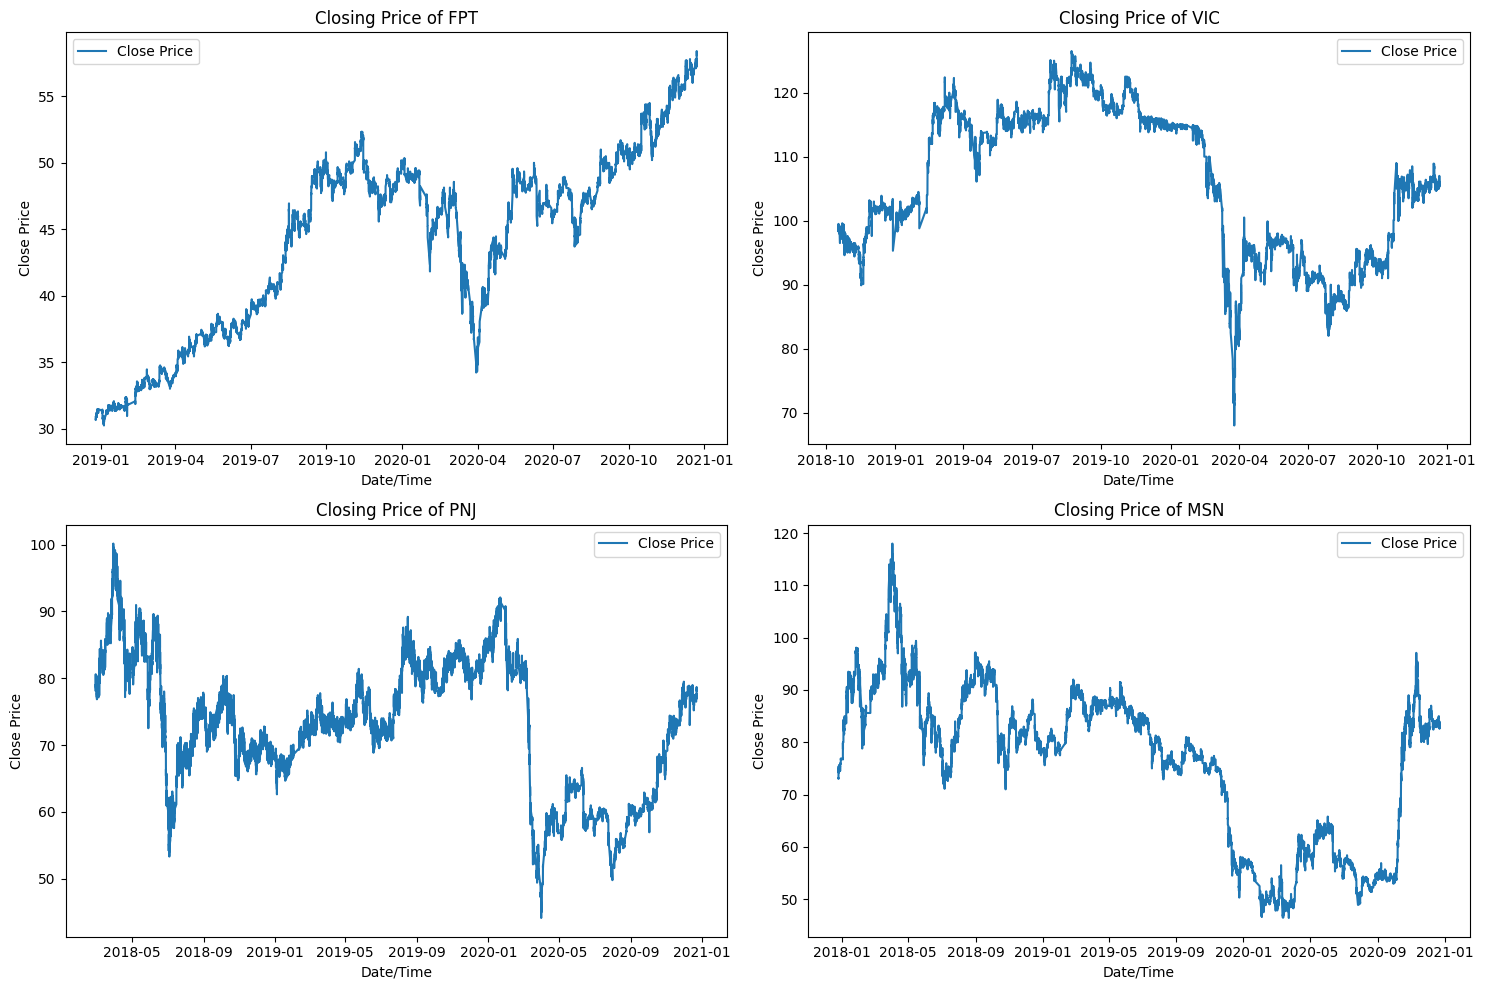

In [5]:
# Plot historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    plt.plot(company['Date/Time'], company['Close'], label='Close Price')
    plt.ylabel('Close Price')
    plt.xlabel('Date/Time')
    plt.title(f"Closing Price of {company_names[i - 1]}")
    plt.legend()

plt.tight_layout()
plt.show()

Plot the total volume of stock being traded each day

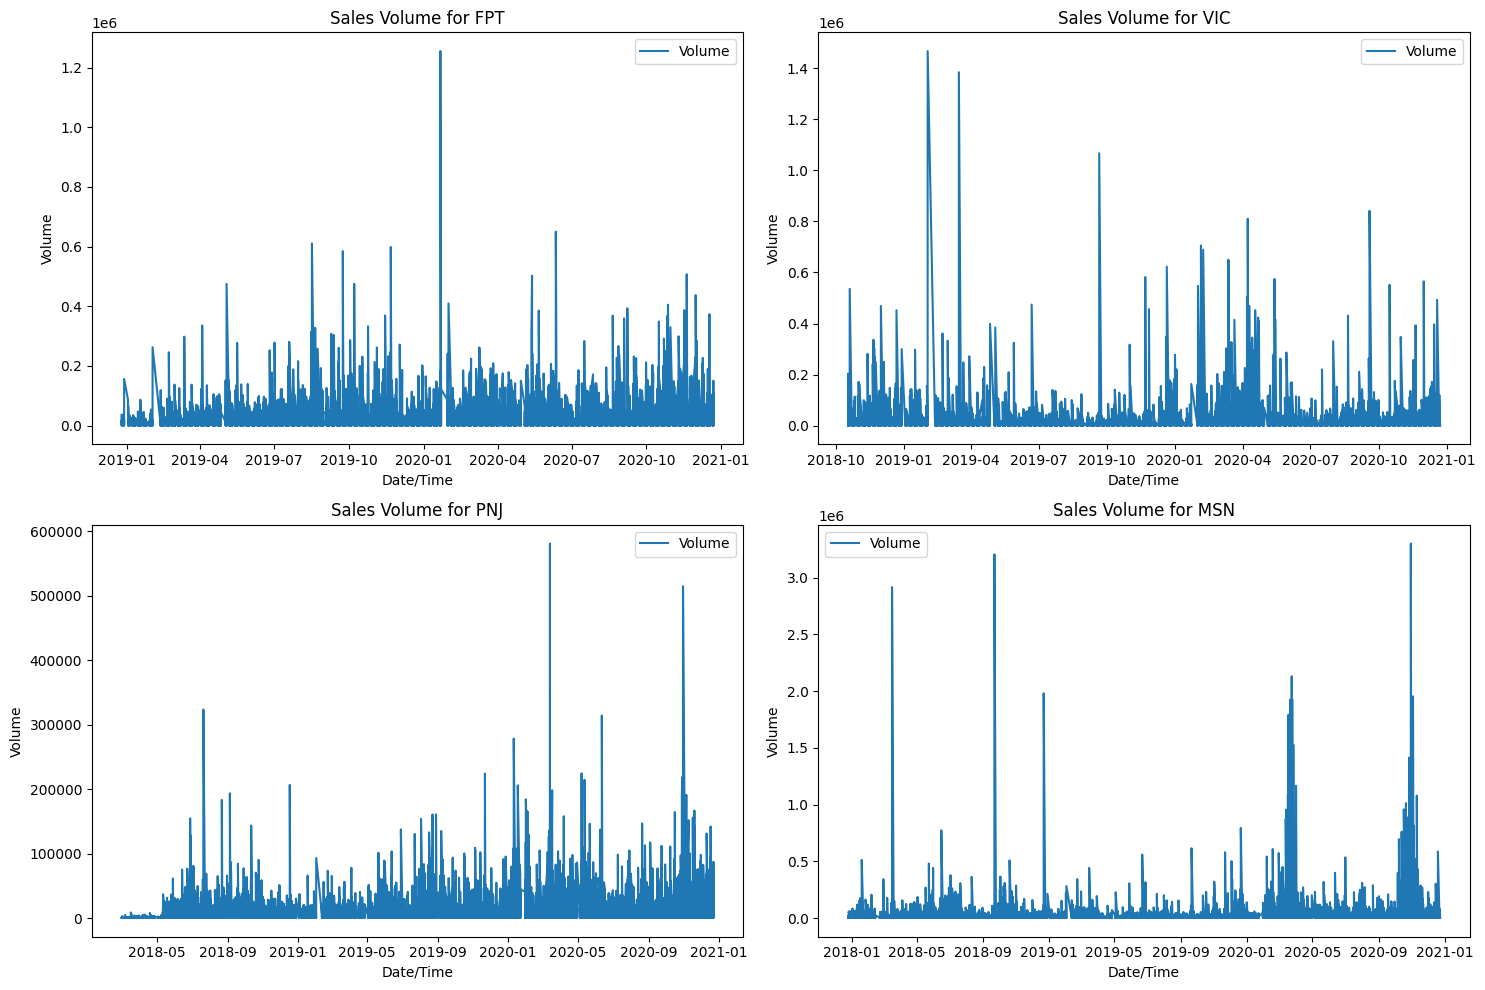

In [6]:
# Plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    plt.plot(company['Date/Time'], company['Volume'], label='Volume')
    plt.ylabel('Volume')
    plt.xlabel('Date/Time')
    plt.title(f"Sales Volume for {company_names[i - 1]}")
    plt.legend()

plt.tight_layout()
plt.show()

# 2. Data Pre-processing


Add extra columns to prepare for the prediction phase

In [11]:
ma_1 = 7
ma_2 = 14
ma_3 = 21
# Function to process each dataset
def process_data(df):
    # df = pd.read_csv(file)
    df['Fluctuation'] = df['Close'].shift(-10) - df['Close']
    df['H-L'] = df['High'] - df['Low']
    df['O-C'] = df['Open'] - df['Close']
    df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
    df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
    df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()
    df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
    df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
    df.dropna(inplace=True)
    return df

Convert the data to numerical data to train the model


In [12]:
# Arrays to store training and testing data
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []

# Process each dataset separately
for file in company_list:
    df = process_data(file)

    # MinMax scaling
    scala_x = MinMaxScaler(feature_range=(0, 1))
    scala_y = MinMaxScaler(feature_range=(0, 1))

    cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
    cols_y = ['Close']

    scaled_data_x = scala_x.fit_transform(df[cols_x])
    scaled_data_y = scala_y.fit_transform(df[cols_y])
    # print(scaled_data_x)

    # Prepare sequences
    pre_day = 30
    x_total = []
    y_total = []

    for i in range(pre_day, len(df)):
        x_total.append(scaled_data_x[i-pre_day:i])
        y_total.append(scaled_data_y[i])

    # Convert to numpy arrays
    x_total = np.array(x_total)
    y_total = np.array(y_total)

    # Split into training and testing sets
    test_size = int(len(x_total) * 0.1)

    x_train = x_total[:-test_size]
    x_test = x_total[-test_size:]
    y_train = y_total[:-test_size]
    y_test = y_total[-test_size:]

    # Save to lists
    x_train_list.append(x_train)
    y_train_list.append(y_train)
    x_test_list.append(x_test)
    y_test_list.append(y_test)


# 3. Train LSTM Model

Training model for FPT
Epoch 1/3
2737/2737 [==============================] - 230s 81ms/step - loss: 0.0016 - val_loss: 9.7764e-04
Epoch 2/3
2737/2737 [==============================] - 220s 80ms/step - loss: 5.3422e-04 - val_loss: 3.2417e-04
Epoch 3/3
304/304 [==============================] - 8s 25ms/step - loss: 0.0012
Test Loss value for FPT: 0.0011997203109785914
304/304 [==============================] - 8s 21ms/step


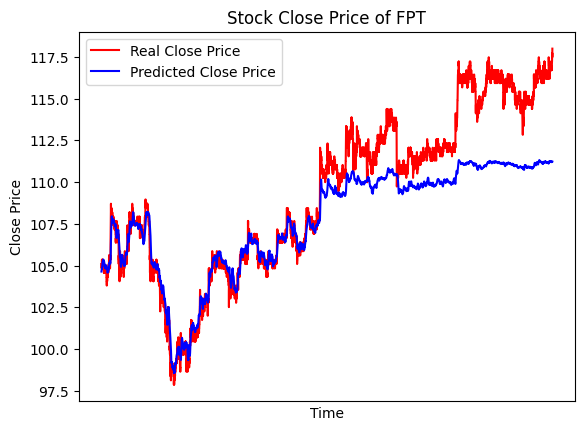

Training model for VIC
Epoch 1/3
2846/2846 [==============================] - 226s 79ms/step - loss: 3.8196e-04 - val_loss: 2.0303e-04
Epoch 2/3
2846/2846 [==============================] - 224s 79ms/step - loss: 3.3311e-04 - val_loss: 5.6433e-05
Epoch 3/3
317/317 [==============================] - 8s 26ms/step - loss: 5.5469e-05
Test Loss value for VIC: 5.5468677601311356e-05
317/317 [==============================] - 9s 24ms/step


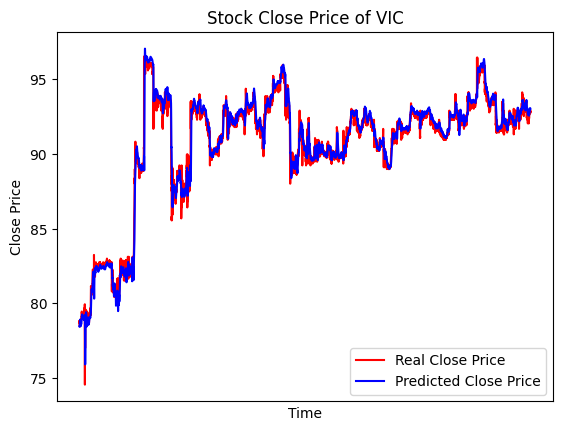

Training model for PNJ
Epoch 1/3
3522/3522 [==============================] - 289s 82ms/step - loss: 4.0296e-04 - val_loss: 4.3573e-05
Epoch 2/3
3522/3522 [==============================] - 284s 81ms/step - loss: 3.4758e-04 - val_loss: 2.8930e-05
Epoch 3/3
392/392 [==============================] - 9s 24ms/step - loss: 5.2493e-05
Test Loss value for PNJ: 5.2492887334665284e-05
392/392 [==============================] - 10s 26ms/step


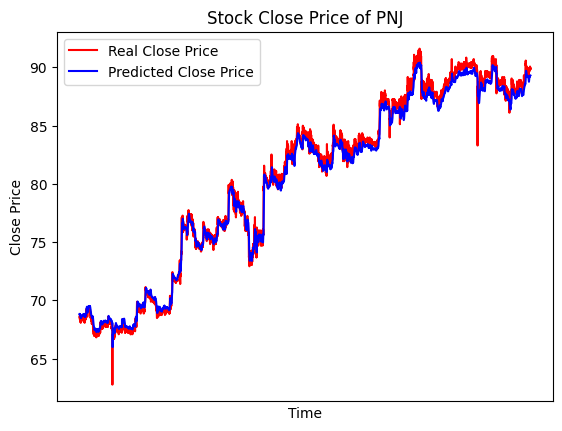

Training model for MSN
Epoch 1/3
3805/3805 [==============================] - 308s 81ms/step - loss: 3.2461e-04 - val_loss: 7.8955e-05
Epoch 2/3
3805/3805 [==============================] - 309s 81ms/step - loss: 3.0199e-04 - val_loss: 4.7239e-05
Epoch 3/3
423/423 [==============================] - 11s 25ms/step - loss: 5.7414e-05
Test Loss value for MSN: 5.7414166803937405e-05
423/423 [==============================] - 10s 24ms/step


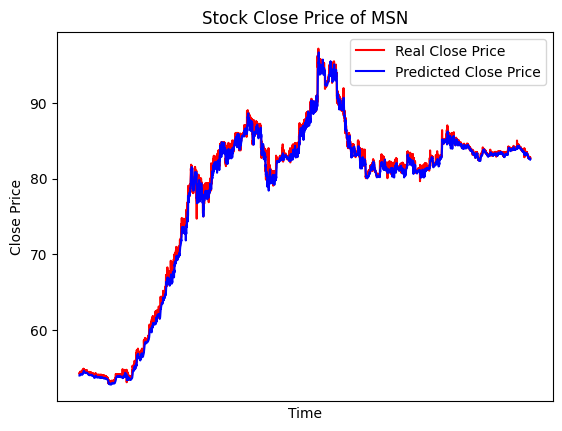

Done Training Model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Build the model
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
for i in range(len(x_train_list)):
    x_train = x_train_list[i]
    y_train = y_train_list[i]
    x_test=x_test_list[i]
    y_test=y_test_list[i]

    print(f"Training model for {company_names[i]}")

    model.fit(x_train, y_train, epochs=3, batch_size=32, validation_data=(x_test, y_test), use_multiprocessing=True)

    # Evaluate the model
    loss = model.evaluate(x_test, y_test)
    print(f"Test Loss value for {company_names[i]}: {loss}")

    # Predict
    predict_close_price = model.predict(x_test)
    predict_close_price = scala_y.inverse_transform(predict_close_price)

    # Compare the predicted close price to the real close price
    real_close_price = scala_y.inverse_transform(y_test)
    plt.plot(real_close_price, color="red", label="Real Close Price")
    plt.plot(predict_close_price, color="blue", label="Predicted Close Price")
    plt.title(f"Stock Close Price of {company_names[i]}")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.xticks([])
    plt.legend()
    plt.show()

# Save the model
model.save("stock_lstm_model.h5")
print("Done Training Model")